In [1]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import torch


colors = ["red", "teal", "gold", "green", "red", "teal", "gold", "green"]

In [3]:
def load_data_mocap(directory: str) -> dict:
    data = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pickle"):
            key, _, _ = filename.rpartition(".")
            with open(os.path.join(directory, filename), "rb") as f:
                v = pickle.load(f)
            if isinstance(v, dict):
                v = (torch.tensor(v["eigenvectors"]), torch.tensor(v["eigenvalues"]))
            else:
                v = torch.tensor(v)
            data[key] = v
    return data


ground_truth_data = load_data_mocap("/cephfs_projects/foundation_models/data/ODE/test/cmu_mocap_43_preprocessed_imputation_percentage_0_2/")
print(list(ground_truth_data.keys()))

['high_dim_trajectory', 'after_imputation_mask', 'observation_grid', 'high_dim_reconst_from_3_pca', 'fine_grid', 'before_imputation_mask', 'observation_mask', 'imputation_mask', 'observation_values', 'pca_params']


In [18]:
# base_path = "/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/MocapData/09-27-2044_trend_overlap0-random_window-interpolated-10-30-soulution/"
# base_path = "/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/MocapData/10-01-1333_trend_overlap0-random_window-interpolated-5-50-soulution/"
base_path = "/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/MocapData/models_trend_overlap0-random_window-interpolated-5-50-soulution"
predictions_high_dim = torch.load(base_path + "high_dim_predictions.pth")

predictions_pca = torch.load(base_path + "pca_predictions.pth")

FileNotFoundError: [Errno 2] No such file or directory: '/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/MocapData/models_trend_overlap0-random_window-interpolated-5-50-soulutionhigh_dim_predictions.pth'

In [19]:
for k, v in predictions_pca.items():
    for ki, vi in v.items():
        print(f"{k:18} {ki:15} : {vi.shape}")

print("---")
for k, v in predictions_high_dim.items():
    for ki, vi in v.items():
        print(f"{k:18} {ki:15} : {vi.shape}")

B, wc, wlen, _ = predictions_pca["observations"]["values"].shape

imputation_window  learnt          : torch.Size([43, 24, 3])
imputation_window  target          : torch.Size([43, 24, 3])
imputation_window  locations       : torch.Size([43, 24, 1])
imputation_window  drift           : torch.Size([43, 24, 3])
imputation_window  drift_certainty : torch.Size([43, 24, 3])
imputation_window  padding_mask_locations : torch.Size([43, 24])
observations       values          : torch.Size([43, 4, 64, 3])
observations       mask            : torch.Size([43, 4, 64, 1])
observations       times           : torch.Size([43, 4, 64, 1])
observations       denoised_values : torch.Size([43, 4, 64, 3])
observations       interpolation   : torch.Size([43, 4, 64, 3])
observations       drift           : torch.Size([43, 4, 64, 3])
observations       drift_certainty : torch.Size([43, 4, 64, 3])
---
imputation_window  learnt          : torch.Size([43, 24, 50])
imputation_window  target          : torch.Size([43, 24, 50])
imputation_window  locations       : torch.Size([43, 2

# Visualizations

In [20]:
# get 16 random samples
torch.manual_seed(0)
# unique sample ids
sample_ids = sorted(torch.randperm(B)[:16])
sample_ids = [v.item() for v in sample_ids]
print(sample_ids)

[1, 2, 3, 4, 12, 13, 14, 19, 22, 26, 28, 29, 30, 31, 40, 42]


In [21]:
def plot_sample(line_plot_data: dict, sample_id: int, dim: int, ax, plot_imputation=True, plot_observations: bool = True):
    batch_size, observed_window_count, _, _ = line_plot_data["observations"]["values"].shape

    if plot_imputation:
        imputation_times = line_plot_data["imputation_window"]["locations"][sample_id]
        imputation_target = line_plot_data["imputation_window"]["target"][sample_id, :, dim]
        imputation_learnt = line_plot_data["imputation_window"]["learnt"][sample_id, :, dim]

    for i in range(observed_window_count):
        if plot_observations:
            obs_mask = line_plot_data["observations"]["mask"][sample_id, i, :, 0]
            obs_times = line_plot_data["observations"]["times"][sample_id, i, :, 0][~obs_mask]
            obs_values = line_plot_data["observations"]["values"][sample_id, i, :, dim][~obs_mask]
            obs_interpolation = line_plot_data["observations"]["interpolation"][sample_id, i, :, dim][~obs_mask]

            ax.scatter(obs_times, obs_values, color=colors[i], marker="x", label=f"observed window {i}")
            ax.plot(obs_times, obs_interpolation, color="black", linestyle="--", label=f"interpolation {i}")
    if plot_imputation:
        ax.plot(imputation_times, imputation_target, color="black", linestyle=":", label="target")
        ax.plot(imputation_times, imputation_learnt, color="blue", label="learnt")
    # axs[0].legend()
    ax.set_title(f"{sample_id}, dim {dim}")
    ax.set_xlabel("Time")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


def plot_drift_sample(line_plot_data: dict, sample_id: int, dim: int, ax):
    obs_mask = line_plot_data["observations"]["mask"][sample_id, ..., 0]
    drift_obs = line_plot_data["observations"]["drift"][sample_id, ..., dim]
    drift_certainty_obs = line_plot_data["observations"]["drift_certainty"][sample_id, ..., dim]
    times_obs = line_plot_data["observations"]["times"][sample_id, ..., 0]

    imp_mask = line_plot_data["imputation_window"]["padding_mask_locations"][sample_id]
    drift_imp = line_plot_data["imputation_window"]["drift"][sample_id, :, dim][~imp_mask]
    drift_certainty_imp = line_plot_data["imputation_window"]["drift_certainty"][sample_id, :, dim][~imp_mask]
    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id, :, 0][~imp_mask]

    for w in range(drift_obs.size(0)):
        ax.plot(times_obs[w][~obs_mask[w]], drift_obs[w][~obs_mask[w]], color=colors[w], linestyle="-", label=f"observed window {w}")
        ax.fill_between(
            times_obs[w][~obs_mask[w]],
            drift_obs[w][~obs_mask[w]] - drift_certainty_obs[w][~obs_mask[w]],
            drift_obs[w][~obs_mask[w]] + drift_certainty_obs[w][~obs_mask[w]],
            alpha=0.3,
            color=colors[w],
        )
    ax.plot(imputation_times, drift_imp, color="blue", label="learnt")
    ax.fill_between(
        imputation_times.squeeze(-1),
        drift_imp - drift_certainty_imp,
        drift_imp + drift_certainty_imp,
        alpha=0.3,
        color="blue",
        label="certainty",
    )
    ax.set_title(f"Drift {sample_id}, dim {dim}")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

## High Dim

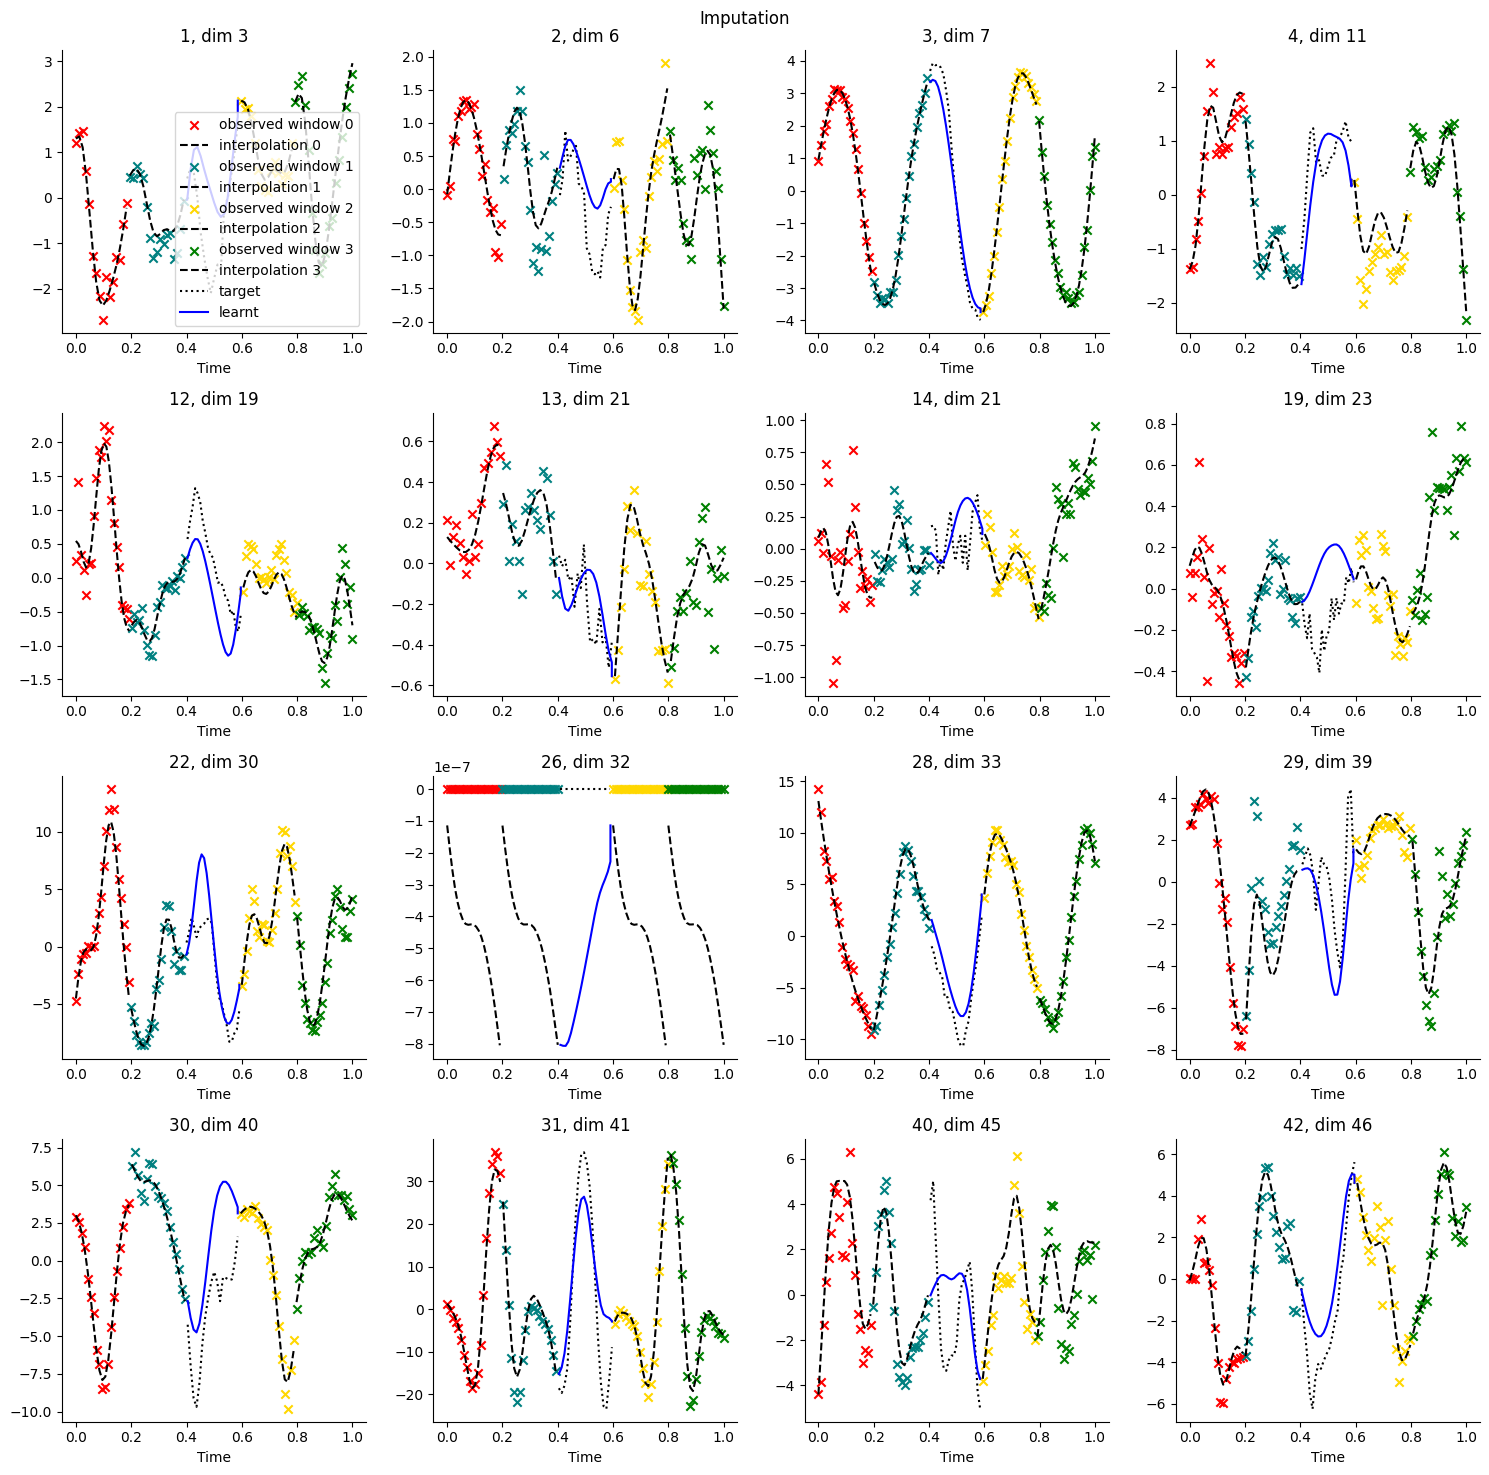

In [22]:
B, wc, wlen, D = predictions_high_dim["observations"]["values"].shape

dims = [v.item() for v in sorted(torch.randint(0, D, (16,)))]


fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for ax, sample_id, dim in zip(axs.flatten(), sample_ids, dims):
    plot_sample(predictions_high_dim, sample_id, dim=dim, ax=ax, plot_observations=True, plot_imputation=True)
fig.suptitle("Imputation")
axs[0, 0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation_high_dim.png")
plt.show()

In [23]:
predictions_high_dim["observations"]["values"][24, 0, :, 25]

tensor([ 6.3478e-16, -2.3468e-14, -3.6140e-14, -6.3972e-15, -1.0348e-14,
        -7.5671e-16, -3.2363e-14,  6.3478e-16,  2.3893e-14,  9.9280e-15,
         1.4401e-14,  2.8960e-15,  7.4929e-15, -9.7517e-15, -1.1491e-14,
         2.6226e-15,  5.0080e-15, -4.7324e-15,  1.0773e-14, -1.0696e-14,
        -7.5154e-15, -6.3227e-15,  4.8093e-15,  2.4238e-15,  1.6736e-14,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00])

# PCA space

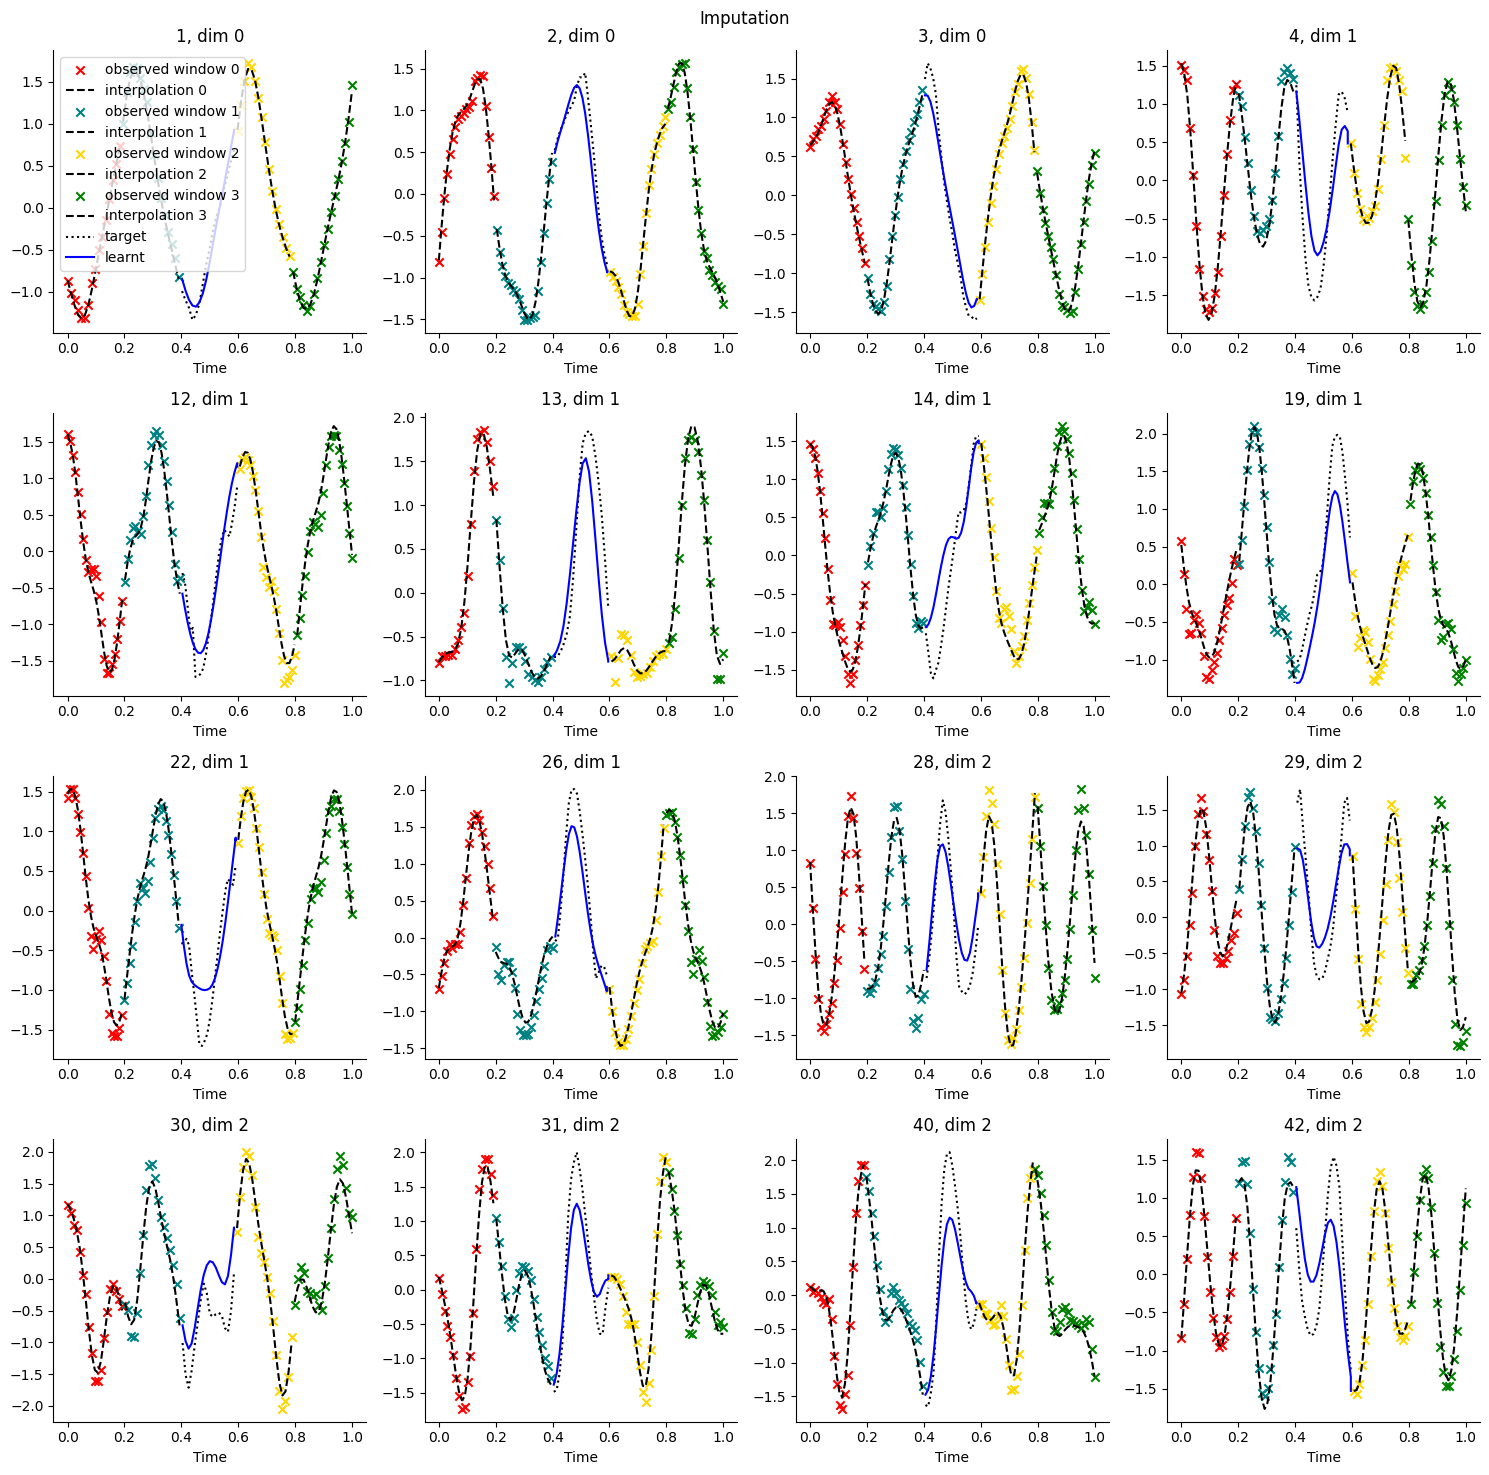

In [ ]:
B, wc, wlen, D = predictions_pca["observations"]["values"].shape

dims = [v.item() for v in sorted(torch.randint(0, D, (16,)))]


fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for ax, sample_id, dim in zip(axs.flatten(), sample_ids, dims):
    plot_sample(predictions_pca, sample_id, dim=dim, ax=ax, plot_observations=True, plot_imputation=True)
fig.suptitle("Imputation")
axs[0, 0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation_pca.png")
plt.show()

# Metrics

In [26]:
metrics_high_dim: dict = json.load(open(base_path + "high_dim_metrics.json", "r"))
print("metrics_high_dim")
print(json.dumps(metrics_high_dim, indent=2))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/MocapData/models_trend_overlap0-random_window-interpolated-5-50-soulutionhigh_dim_metrics.json'

In [27]:
metrics_pca: dict = json.load(open(base_path + "pca_metrics.json", "r"))
print("metrics_pca")
print(json.dumps(metrics_pca, indent=2))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/MocapData/models_trend_overlap0-random_window-interpolated-5-50-soulutionpca_metrics.json'

# plot single samples

In [28]:
# get sample id of worst performing prediction
predictions = predictions_pca  # or predictions_pca
performance = ((predictions["imputation_window"]["target"] - predictions["imputation_window"]["learnt"]) ** 2).mean(dim=1).mean(dim=1)
print("performance per sample")
print(performance)
print(performance.mean())
print(torch.sqrt(performance.mean()))

performance per sample
tensor([0.1605, 0.0815, 0.0900, 0.3048, 0.1577, 0.1848, 0.1230, 0.1420, 0.0587,
        0.2493, 0.1206, 0.0978, 0.2941, 0.2386, 0.3942, 0.1083, 0.1293, 0.1577,
        0.1551, 0.2867, 0.1151, 0.0859, 0.2883, 0.0959, 0.2448, 0.2887, 0.1458,
        0.1187, 0.0869, 0.0907, 0.2467, 0.2175, 0.2271, 0.1346, 0.1223, 0.1754,
        0.1970, 0.1376, 0.1586, 0.1306, 0.1916, 0.2203, 0.2747])
tensor(0.1751)
tensor(0.4185)


In [29]:
(predictions["imputation_window"]["target"][0, :-8, :] - predictions["imputation_window"]["learnt"][0, :-8, :]).mean(dim=0).mean(dim=0)

tensor(-0.2788)

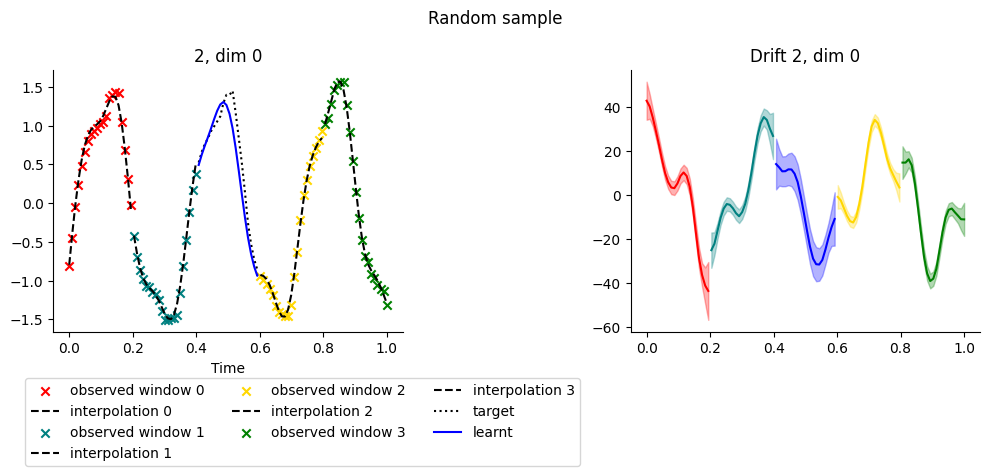

In [31]:
# random sample
sample_id = 2
dim = 0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, sample_id, dim, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, sample_id, dim, axs[1])

fig.suptitle("Random sample")
plt.tight_layout()
plt.savefig(base_path + f"sample{sample_id}.png")
plt.show()

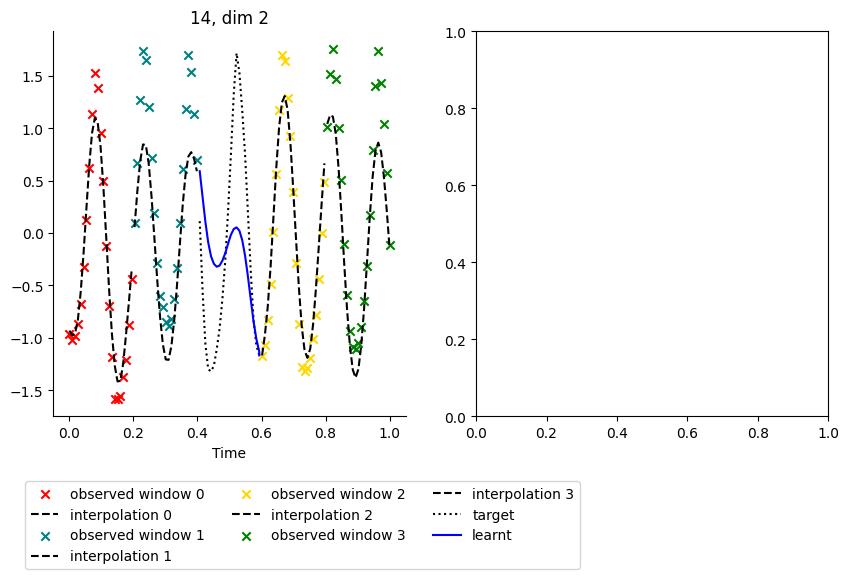

In [32]:
# worst performing sample
worst_sample_id = performance.argmax().item()

# plot worst performing samplexx
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, worst_sample_id, 2, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))

# plot_drift_sample(predictions, worst_sample_id, 2, axs[1])
# fig.suptitle("Worst performing sample")
# plt.tight_layout()
# plt.savefig(base_path + f"worst_sample{worst_sample_id}.png")

# # second worst performing sample
# second_worst_sample_id = performance.argsort()[1].item()

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot_sample(predictions, second_worst_sample_id, 2,  axs[0])
# axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(-0.1, -0.15))
# plot_drift_sample(predictions, second_worst_sample_id, 2, axs[1])
# fig.suptitle("Second worst performing sample")
# plt.tight_layout()
# plt.savefig(base_path + f"second_worst_sample{second_worst_sample_id}.png")
# plt.show()

# # best performing sample
# best_sample_id = performance.argmin().item()

# # plot best performing sample
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot_sample(predictions, best_sample_id, 2,  axs[0])
# axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(-0.1, -0.15))

# plot_drift_sample(predictions, best_sample_id, 2, axs[1])
# fig.suptitle("Best performing sample")
# plt.tight_layout()
# plt.savefig(base_path + f"best_sample{best_sample_id}.png")
# plt.show()